# Movie Ratings Sentiment Analysis

In [1]:
!git clone https://github.com/akhmad-ardi/IMDB_Movie_Ratings_Sentiment_Analysis.git

fatal: destination path 'IMDB_Movie_Ratings_Sentiment_Analysis' already exists and is not an empty directory.


### **Import Library**

In [2]:
import random
import numpy as np
import pandas as pd
import torch
import nltk
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, BertModel

from IMDB_Movie_Ratings_Sentiment_Analysis.utils.forward_fn import forward_sequence_classification
from IMDB_Movie_Ratings_Sentiment_Analysis.utils.metrics import document_sentiment_metrics_fn
from IMDB_Movie_Ratings_Sentiment_Analysis.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [5]:
# Set random seed
set_seed(27012025)

In [6]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
config = BertConfig.from_pretrained('google-bert/bert-base-uncased')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Data Acquisition

### Load Dataset

In [8]:
import kagglehub

path = kagglehub.dataset_download("yasserh/imdb-movie-ratings-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/imdb-movie-ratings-sentiment-analysis/versions/1


In [9]:
dataset_path = f"{path}/movie.csv"
df = pd.read_csv(dataset_path)

df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## Data cleaning

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [11]:
df.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


#### Duplicate

In [12]:
# Check duplicates
print(f"Total Duplicates: {df.duplicated().sum()}")

duplicates = df[df.duplicated(keep=False)]
print(duplicates)

Total Duplicates: 277
                                                    text  label
202    "Go Fish" garnered Rose Troche rightly or wron...      0
253    A fun romp...a lot of good twists and turns! (...      1
266    Mean spirited, and down right degrading adapta...      0
339    (Spoilers)<br /><br />Oh sure it's based on Mo...      0
654    You do realize that you've been watching the E...      0
...                                                  ...    ...
39229  I Enjoyed Watching This Well Acted Movie Very ...      1
39246  You do realize that you've been watching the E...      0
39508  (Spoilers)<br /><br />Oh sure it's based on Mo...      0
39681  It's been a long time since I last saw a movie...      0
39746  Goodnight, Mister Tom begins in an impossibly ...      0

[546 rows x 2 columns]


In [13]:
# Drop duplicates
df.drop_duplicates(inplace=True)

print(df.duplicated().sum())

0


#### Miss Value

In [14]:
# Check for missing values in each column
print(df.isnull().sum())

text     0
label    0
dtype: int64


## Data Preprocessing

In [15]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Now you have three datasets: train_df, val_df, and test_df
print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (31778, 2)
Validation set shape: (3972, 2)
Test set shape: (3973, 2)


In [16]:
train_dataset = DocumentSentimentDataset(train_df, tokenizer, lowercase=True)
validation_dataset = DocumentSentimentDataset(val_df, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_df, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
validation_loader = DocumentSentimentDataLoader(dataset=validation_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
print(train_loader)

In [18]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 1, 'negative': 0}
{1: 'positive', 0: 'negative'}


## Model

### Test Pretrained Model

In [19]:
text = 'I like this movie'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: I like this movie | Label : positive (62.065%)


### Fine Tuning Model

In [20]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [21]:
# Train
n_epochs = 3
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(validation_loader, leave=True, total=len(validation_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))


(Epoch 1) TRAIN LOSS:0.3892 LR:0.00000300: 100%|██████████| 994/994 [48:03<00:00,  2.90s/it]


(Epoch 1) TRAIN LOSS:0.3892 ACC:0.81 F1:0.81 REC:0.81 PRE:0.81 LR:0.00000300


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2650 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90: 100%|██████████| 125/125 [01:59<00:00,  1.05it/s]


(Epoch 1) VALID LOSS:0.2650 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90


  0%|          | 0/994 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 2) TRAIN LOSS:0.2404 LR:0.00000300: 100%|██████████| 994/994 [47:59<00:00,  2.90s/it]


(Epoch 2) TRAIN LOSS:0.2404 ACC:0.90 F1:0.90 REC:0.90 PRE:0.90 LR:0.00000300


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2370 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91: 100%|██████████| 125/125 [01:58<00:00,  1.06it/s]


(Epoch 2) VALID LOSS:0.2370 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91


  0%|          | 0/994 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 3) TRAIN LOSS:0.2013 LR:0.00000300: 100%|██████████| 994/994 [47:55<00:00,  2.89s/it]


(Epoch 3) TRAIN LOSS:0.2013 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92 LR:0.00000300


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.2348 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92: 100%|██████████| 125/125 [01:58<00:00,  1.05it/s]

(Epoch 3) VALID LOSS:0.2348 ACC:0.92 F1:0.92 REC:0.92 PRE:0.92


## Model Evaluation

In [22]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 125/125 [01:54<00:00,  1.09it/s]


In [23]:
text = 'I like this movie'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: I like this movie | Label : positive (93.577%)


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 125/125 [01:55<00:00,  1.08it/s]


              precision    recall  f1-score   support

    negative       0.91      0.91      0.91      2011
    positive       0.91      0.91      0.91      1962

    accuracy                           0.91      3973
   macro avg       0.91      0.91      0.91      3973
weighted avg       0.91      0.91      0.91      3973



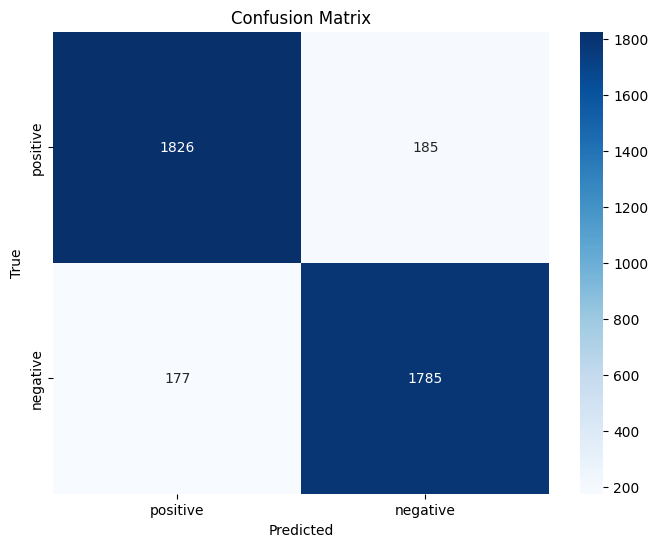

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Model Evaluation Matics
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_label


# classification report
print(classification_report(list_label, list_hyp))

# confusion matrix
cm = confusion_matrix(list_label, list_hyp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=i2w.values(), yticklabels=i2w.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()